
# Example: Time Series Model - Bouncing MNIST in NumPyro

This example illustrates how to construct an inference program based on the APGS
sampler [1] for BMNIST. The details of BMNIST can be found in the sections
6.4 and F.3 of the reference. We will use the NumPyro (default) backend for this
example.

**References**

    1. Wu, Hao, et al. Amortized population Gibbs samplers with neural
       sufficient statistics. ICML 2020.

<img src="file://../_static/bmnist.gif" align="center">


In [1]:
import argparse
from functools import partial

import coix
import flax.linen as nn
import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from optax import cosine_decay_schedule
from optax import clip_by_global_norm
import tensorflow as tf
import tensorflow_datasets as tfds

from sim_utils import *

/home/frans/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-03 17:22:40.044721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 17:22:40.054860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 17:22:40.057699: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 17:22:40.573524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi

First, let's load the moving mnist dataset.



In [2]:
# def load_dataset(*, is_training, batch_size):
#   ds = tfds.load("moving_mnist:1.0.0", split="test")
#   ds = ds.repeat()
#   if is_training:
#     ds = ds.shuffle(10 * batch_size, seed=0)
#     map_fn = lambda x: x["image_sequence"][..., :10, :, :, 0] / 255
#   else:
#     map_fn = lambda x: x["image_sequence"][..., 0] / 255
#   ds = ds.batch(batch_size)
#   ds = ds.map(map_fn)
#   return iter(tfds.as_numpy(ds))

def load_dataset(*, is_training, batch_size, n_data = -1):
  # ds = np.load("worms_train_20k.npy")
  ds = np.load("worms_train.npy")
  ds = ds[:n_data]

  # make ds a tensor, and batch it
  ds = tf.data.Dataset.from_tensor_slices(ds)
  ds = ds.repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  # standardize the data between 0 and 1
  ds = ds.map(lambda x: x / 0.80999994)
  return iter(tfds.as_numpy(ds))

def get_digit_mean():
  ds, ds_info = tfds.load("mnist:3.0.1", split="train", with_info=True)
  ds = tfds.as_numpy(ds.batch(ds_info.splits["train"].num_examples))
  digit_mean = next(iter(ds))["image"].squeeze(-1).mean(axis=0)
  return digit_mean / 255

In [3]:
def get_digit_mean():
  ds, ds_info = tfds.load("mnist:3.0.1", split="train", with_info=True)
  ds = tfds.as_numpy(ds.batch(ds_info.splits["train"].num_examples))
  digit_mean = next(iter(ds))["image"].squeeze(-1).mean(axis=0)
  return digit_mean / 255

Next, we define the neural proposals for the Gibbs kernels and the neural
decoder for the generative model.



In [4]:
def vmapped_sim_fn(sim_fn, params):
    # print(jax.tree_map(lambda x: x.shape if hasattr(x, 'shape') else None, params))
    if params['L'].ndim == 1:
        return jax.vmap(sim_fn, in_axes=0, out_axes=0)(params)
    else:
        return jax.vmap(partial(vmapped_sim_fn, sim_fn), in_axes=0, out_axes=0)(params)

In [5]:
def sim_worms(nworms, batch_size, n_frames):
    duration = 0.55
    snapshots = 10
    kpoints = 6
    box_size = 64
    with numpyro.plate('batch', batch_size, dim=-2):
        with numpyro.plate('nworms', nworms, dim=-1):
            # L = numpyro.sample('L', dist.Uniform(30, 45))
            L = numpyro.sample('L', dist.Uniform(10, 15))
            A = numpyro.sample('A', dist.Normal(1, 0.1))
            T = numpyro.sample('T', dist.Normal(0.8, 0.1))
            kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi))
            ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1))
            
            inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi))
            dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8))
            phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi))
            phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi))
            phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1))
            alpha = numpyro.sample('alpha', dist.Normal(4, 4))

            alpha = jnp.abs(alpha + 1.0)
            half_box = box_size // 2
            x0 = numpyro.sample('x0', dist.Uniform(-1, 1))
            y0 = numpyro.sample('y0', dist.Uniform(-1, 1))
            x0 = x0 * half_box
            y0 = y0 * half_box

            params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}

            # # L is a tensor. Assert that all values are within the range
            # assert jnp.all(L >= 10) and jnp.all(L <= 15), f"L: {L}"
            # # kw
            # assert jnp.all(kw >= 0) and jnp.all(kw <= 2 * jnp.pi), f"kw: {kw}"
            # # inc
            # assert jnp.all(inc >= 0) and jnp.all(inc <= 2 * jnp.pi), f"inc: {inc}"
            # # dr
            # assert jnp.all(dr >= 0.2) and jnp.all(dr <= 0.8), f"dr: {dr}"
            # # phase_1
            # assert jnp.all(phase_1 >= 0) and jnp.all(phase_1 <= 2 * jnp.pi), f"phase_1: {phase_1}"
            # # phase_2
            # assert jnp.all(phase_2 >= 0) and jnp.all(phase_2 <= 2 * jnp.pi), f"phase_2: {phase_2}"
            # # x0
            # assert jnp.all(x0 >= -1) and jnp.all(x0 <= 1), f"x0: {x0}"
            # # y0
            # assert jnp.all(y0 >= -1) and jnp.all(y0 <= 1), f"y0: {y0}"

            sim_fn = partial(
                worm_simulation,
                duration=duration,
                snapshots=snapshots,
                kpoints=kpoints,
            )

            with numpyro.plate('n_frames', n_frames):
                worms = vmapped_sim_fn(sim_fn, params)
                
                worms = worms + half_box
                # subtract mean and divide by standard deviation
                worms = (worms - jnp.mean(worms, axis=(-5), keepdims=True)) / jnp.std(worms, axis=(-5), keepdims=True)
                numpyro.deterministic('worms', worms)
    return worms, x0, y0

In [6]:
def scale_and_translate(image, where, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )


def crop_frames(frames, z_where, digit_size=14):
  # frames:           time.frame_size.frame_size
  # z_where: (digits).time.2
  # out:     (digits).time.digit_size.digit_size
  if frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(frames, z_where, out_size=digit_size)
  elif frames.ndim == 3 and z_where.ndim == 2:
    in_axes = (0, 0)
  elif frames.ndim == 3 and z_where.ndim == 3:
    in_axes = (None, 0)
  elif frames.ndim == z_where.ndim:
    in_axes = (0, 0)
  elif frames.ndim > z_where.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(partial(crop_frames, digit_size=digit_size), in_axes)(
      frames, z_where
  )


def embed_digits(digits, z_where, frame_size=64):
  # digits:  (digits).      .digit_size.digit_size
  # z_where: (digits).(time).2
  # out:     (digits).(time).frame_size.frame_size
  if digits.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(digits, z_where, out_size=frame_size)
  elif digits.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0)
  elif digits.ndim >= z_where.ndim:
    in_axes = (0, 0)
  else:
    in_axes = (None, 0)
  # print("in_axes", in_axes)
  # print(digits.shape)
  # print(z_where.shape)
  return jax.vmap(partial(embed_digits, frame_size=frame_size), in_axes)(
      digits, z_where
  )

  

def conv2d(frames, digits):
  # frames:          (time).frame_size.frame_size
  # digits: (digits).      .digit_size.digit_size
  # out:    (digits).(time).conv_size .conv_size
  if frames.ndim == 2 and digits.ndim == 2:
    return jax.scipy.signal.convolve2d(frames, digits, mode="valid")
  elif frames.ndim == digits.ndim:
    in_axes = (0, 0)
  elif frames.ndim > digits.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(conv2d, in_axes=in_axes)(frames, digits)


# class EncoderWhat(nn.Module):

#   @nn.compact
#   def __call__(self, digits):
#     x = digits.reshape(digits.shape[:-2] + (-1,)) # flatten frame into vector
#     x = nn.Dense(400)(x)
#     x = nn.relu(x)
#     x = nn.Dense(200)(x)
#     x = nn.relu(x)

#     x = x.sum(-2)  # sum/mean across time
#     loc_raw = nn.Dense(10)(x)
#     scale_raw = 0.5 * nn.Dense(10)(x)
#     return loc_raw, jnp.exp(scale_raw)


In [7]:
class EncoderWhat(nn.Module):

  @nn.compact
  def __call__(self, digits, carry=None):
    mappable_dims = digits.shape[:-3]
    
    hidden_dim = 128

    x = digits.reshape(digits.shape[:-2] + (-1,)) # flatten frame into vector
    if carry is None:
      carry = self.param('carry_init', 
                         lambda rng, shape: jnp.zeros(shape), 
                         mappable_dims + (hidden_dim,))
    GRU = nn.scan(nn.GRUCell,
                  in_axes=-1,
                  variable_broadcast='params',
                  split_rngs={'params': False}
                  )(hidden_dim)
    # print(carry.shape)
    # print(x.shape)
    # add layernorm
    
    x = nn.LayerNorm()(x)
    x,_ = GRU(carry, x)
    x = nn.relu(x)
    x = nn.Dense(64)(x)
    x = nn.relu(x)
    x = nn.LayerNorm()(x)
    
    x_L = nn.Dense(10)(x)
    x_L = nn.relu(x_L)
    x_L_loc = nn.Dense(1)(x_L)
    # scale to 10-15
    x_L_loc = nn.tanh(x_L_loc) * 2.5 + 12.5
    x_L_scale = 0.5 * nn.Dense(1)(x_L)

    x_A = nn.Dense(10)(x)
    x_A = nn.relu(x_A)
    x_A_loc = nn.Dense(1)(x_A)
    x_A_scale = 0.5 * nn.Dense(1)(x_A)

    x_T = nn.Dense(10)(x)
    x_T = nn.relu(x_T)
    x_T_loc = nn.Dense(1)(x_T)
    # constrain to positive
    x_T_loc = nn.softplus(x_T_loc)
    x_T_scale = 0.5 * nn.Dense(1)(x_T)

    x_kw = nn.Dense(10)(x)
    x_kw = nn.relu(x_kw)
    x_kw_loc = nn.Dense(1)(x_kw)
    # scale to 0-2pi
    x_kw_loc = nn.tanh(x_kw_loc) * jnp.pi + jnp.pi
    x_kw_scale = 0.5 * nn.Dense(1)(x_kw)

    x_ku = nn.Dense(10)(x)
    x_ku = nn.relu(x_ku)
    x_ku_loc = nn.Dense(1)(x_ku)
    x_ku_scale = 0.5 * nn.Dense(1)(x_ku)

    x_inc = nn.Dense(10)(x)
    x_inc = nn.relu(x_inc)
    x_inc_loc = nn.Dense(1)(x_inc)
    # scale to 0-2pi
    x_inc_loc = nn.tanh(x_inc_loc) * jnp.pi + jnp.pi
    x_inc_scale = 0.5 * nn.Dense(1)(x_inc)

    x_dr = nn.Dense(10)(x)
    x_dr = nn.relu(x_dr)
    x_dr_loc = nn.Dense(1)(x_dr)
    # scale to 0.2-0.8
    x_dr_loc = nn.tanh(x_dr_loc) * 0.3 + 0.5
    x_dr_scale = 0.5 * nn.Dense(1)(x_dr)

    x_phase_1 = nn.Dense(10)(x)
    x_phase_1 = nn.relu(x_phase_1)
    x_phase_1_loc = nn.Dense(1)(x_phase_1)
    # scale to 0-2pi
    x_phase_1_loc = nn.tanh(x_phase_1_loc) * jnp.pi + jnp.pi
    x_phase_1_scale = 0.5 * nn.Dense(1)(x_phase_1)

    x_phase_2 = nn.Dense(10)(x)
    x_phase_2 = nn.relu(x_phase_2)
    x_phase_2_loc = nn.Dense(1)(x_phase_2)
    # scale to 0-2pi
    x_phase_2_loc = nn.tanh(x_phase_2_loc) * jnp.pi + jnp.pi
    x_phase_2_scale = 0.5 * nn.Dense(1)(x_phase_2)

    x_phase_3 = nn.Dense(10)(x)
    x_phase_3 = nn.relu(x_phase_3)
    x_phase_3_loc = nn.Dense(1)(x_phase_3)
    x_phase_3_scale = 0.5 * nn.Dense(1)(x_phase_3)

    x_alpha = nn.Dense(10)(x)
    x_alpha = nn.relu(x_alpha)
    x_alpha_loc = nn.Dense(1)(x_alpha)
    x_alpha_scale = 0.5 * nn.Dense(1)(x_alpha)

    x_x0_loc = nn.Dense(1)(x)
    x_x0_loc = nn.tanh(x_x0_loc) * 1
    x_x0_scale = 0.5 * nn.Dense(1)(x)

    x_y0_loc = nn.Dense(1)(x)
    x_y0_loc = nn.tanh(x_y0_loc) * 1
    x_y0_scale = 0.5 * nn.Dense(1)(x)

    # return x_L_loc, jnp.exp(x_L_scale), x_A_loc, jnp.exp(x_A_scale), x_T_loc, jnp.exp(x_T_scale), x_kw_loc, jnp.exp(x_kw_scale), x_ku_loc, jnp.exp(x_ku_scale), x_inc_loc, jnp.exp(x_inc_scale), x_dr_loc, jnp.exp(x_dr_scale), x_phase_1_loc, jnp.exp(x_phase_1_scale), x_phase_2_loc, jnp.exp(x_phase_2_scale), x_phase_3_loc, jnp.exp(x_phase_3_scale), x_alpha_loc, jnp.exp(x_alpha_scale)
    return x_L_loc.squeeze(-1), jnp.exp(x_L_scale.squeeze(-1)), x_A_loc.squeeze(-1), jnp.exp(x_A_scale.squeeze(-1)), x_T_loc.squeeze(-1), jnp.exp(x_T_scale.squeeze(-1)), x_kw_loc.squeeze(-1), jnp.exp(x_kw_scale.squeeze(-1)), x_ku_loc.squeeze(-1), jnp.exp(x_ku_scale.squeeze(-1)), x_inc_loc.squeeze(-1), jnp.exp(x_inc_scale.squeeze(-1)), x_dr_loc.squeeze(-1), jnp.exp(x_dr_scale.squeeze(-1)), x_phase_1_loc.squeeze(-1), jnp.exp(x_phase_1_scale.squeeze(-1)), x_phase_2_loc.squeeze(-1), jnp.exp(x_phase_2_scale.squeeze(-1)), x_phase_3_loc.squeeze(-1), jnp.exp(x_phase_3_scale.squeeze(-1)), x_alpha_loc.squeeze(-1), jnp.exp(x_alpha_scale.squeeze(-1)), x_x0_loc.squeeze(-1), jnp.exp(x_x0_scale.squeeze(-1)), x_y0_loc.squeeze(-1), jnp.exp(x_y0_scale.squeeze(-1))



# class EncoderWhere(nn.Module):

#   @nn.compact
#   def __call__(self, frame_conv):
#     x = frame_conv.reshape(frame_conv.shape[:-2] + (-1,))
#     x = nn.softmax(x, -1)
#     x = nn.Dense(200)(x)
#     x = nn.relu(x)
#     x = nn.Dense(200)(x)
#     x = x.reshape(x.shape[:-1] + (2, 100))
#     x = nn.relu(x)
#     loc_raw = nn.Dense(2)(x[..., 0, :])
#     scale_raw = 0.5 * nn.Dense(2)(x[..., 1, :])
#     return nn.tanh(loc_raw), jnp.exp(scale_raw)

class EncoderWhere(nn.Module):

  @nn.compact
  def __call__(self, frame_conv):
    x = frame_conv.reshape(frame_conv.shape[:-2] + (-1,))
    # # concatenate worm_means to x
    # if worm_means is None:
    #   worm_means = jnp.zeros(x.shape[:-1] + (2,))
    # x = jnp.concatenate([x, jnp.zeros(x.shape[:-1] + (1,))], axis=-1)
    x = nn.softmax(x, -1)
    x = nn.Dense(200)(x)
    x = nn.relu(x)
    x = nn.Dense(200)(x)
    x = x.reshape(x.shape[:-1] + (2, 100))
    x = nn.relu(x)
    loc_raw = nn.Dense(2)(x[..., 0, :])
    scale_raw = 0.5 * nn.Dense(2)(x[..., 1, :])
    # return nn.tanh(loc_raw), jnp.exp(scale_raw)
    return nn.tanh(loc_raw), nn.sigmoid(scale_raw)


class DecoderWhat(nn.Module):

  @nn.compact
  def __call__(self, z_what):
    # print("z_what.shape DecoderWhat", z_what.shape)
    x = z_what.reshape(z_what.shape[:-2] + (-1,)) # flatten knots x 2 into vector
    # print("x.shape DecoderWhat", x.shape)
    x = nn.Dense(50)(x)
    x = nn.relu(x)
    x = nn.Dense(100)(x)
    x = nn.relu(x)
    x = nn.Dense(196)(x)
    logits = x.reshape(x.shape[:-1] + (14, 14))
    return nn.sigmoid(logits)


class BMNISTAutoEncoder(nn.Module):
  digit_mean: jnp.ndarray
  frame_size: int

  def setup(self):
    self.encode_what = EncoderWhat()
    self.encode_where = EncoderWhere()
    self.decode_what = DecoderWhat()

  def __call__(self, frames):
    num_particles, batch_size, T, frame_size, frame_size = frames.shape
    # Heuristic procedure to setup initial parameters.

    z_where = []
    for t in range(10):
      frame = frames[..., t, :, :]
      z_where_d = []
      for d in range(2):
        frames_conv = conv2d(frame, self.digit_mean)
        # if t == 0:
        #   plt.figure()
        #   plt.imshow(frame[0,0])
        #   plt.figure()
        #   plt.imshow(self.digit_mean)
        #   plt.figure()
        #   plt.imshow(frames_conv[0,0])
        z_where_t_d, _ = self.encode_where(frames_conv)
        z_where_d.append(z_where_t_d)
      z_where_d = jnp.stack(z_where_d, -2)
      z_where.append(z_where_d)
    # z_where = jnp.stack(z_where, -3).transpose(0, 2, 1, 3)
    z_where = jnp.stack(z_where, -3).transpose(0, 1, 3, 2, 4)
    # print(z_where.shape)
    print("z_where.shape", z_where.shape)
    digits = crop_frames(frames, z_where, 14)
    # print(digits.shape)
    print("digits.shape", digits.shape)
    # z_what, _ = self.encode_what(digits)
    proposed_sim_params = self.encode_what(digits)
    print(proposed_sim_params[0].shape)
    # proposed_sim_params = jax.tree_map(lambda x: x.squeeze(-1), proposed_sim_params)
    # x0, y0 = z_where[..., 0, 0].squeeze(), z_where[..., 0, 1].squeeze()
    x0, y0 = z_where[..., 0, 0], z_where[..., 0, 1]
    assert x0.shape == proposed_sim_params[0].shape, f"x0.shape: {x0.shape}, proposed_sim_params[0].shape: {proposed_sim_params[0].shape}"
    worm_sim = numpyro.handlers.condition(sim_worms, {'L': proposed_sim_params[0], 'A': proposed_sim_params[2], 'T': proposed_sim_params[4], 'kw': proposed_sim_params[6], 'ku': proposed_sim_params[8], 'inc': proposed_sim_params[10], 'dr': proposed_sim_params[12], 'phase_1': proposed_sim_params[14], 'phase_2': proposed_sim_params[16], 'phase_3': proposed_sim_params[18], 'alpha': proposed_sim_params[20], 'x0': x0, 'y0': y0})
    worm_trace = numpyro.handlers.trace(worm_sim).get_trace(2, batch_size, T)
    worms = worm_trace["worms"]["value"]
    # print(worms.shape)
    print("worms.shape", worms.shape)
    print(worms.mean(), worms.std())

    digit_recon = self.decode_what(worms)
    # print(digit_recon.shape)
    print("digit_recon.shape", digit_recon.shape)
    frames_recon = embed_digits(digit_recon, z_where, self.frame_size)
    # print(frames_recon.shape)
    print("frames_recon.shape", frames_recon.shape)
    # check for nans
    if jnp.any(jnp.isnan(frames_recon)):
      print("frames_recon has nans")
    if jnp.any(jnp.isnan(digit_recon)):
      print("digit_recon has nans")
    if jnp.any(jnp.isnan(worms)):
      print("worms has nans")
      # print the proposed sim params where worms is nan
      print(proposed_sim_params[0][jnp.isnan(worms)])
    if jnp.any(jnp.isnan(digits)):
      print("digits has nans")
    if jnp.any(jnp.isnan(frames)):
      print("frames has nans")
    if jnp.any(jnp.isnan(z_where)):
      print("z_where has nans")
    return frames_recon

Then, we define the target and kernels as in Section 6.4.



In [8]:
def bmnist_target(network, inputs, batch_size=3, D=2, T=10):
   
  worms, x0s, y0s = sim_worms(D, batch_size, T)

  z_where = []
  # worm_frames = []
  worm_frames = network.decode_what(worms)
  for d in range(D):
    z_where_d = []
    # z_where_d_t = jnp.array([x0s[d], y0s[d]])
    z_where_d_t = jnp.zeros(2)
    for t in range(T):
      # worm_frame = network.decode_what(worms[..., t, d, :, :])
      # worm_frames.append(worm_frame)
      scale = 1 if t == 0 else 0.01
      z_where_d_t = numpyro.sample(
          f"z_where_{d}_{t}", dist.Normal(z_where_d_t, scale).to_event(1)
      )
      z_where_d.append(z_where_d_t)
    z_where_d = jnp.stack(z_where_d, -2)
    z_where.append(z_where_d)
  z_where = jnp.stack(z_where, -3)
  z_where = z_where.squeeze()

  # print("worm_frames target", worm_frames.shape)
  # print("z_where target", z_where.shape)
  p = embed_digits(worm_frames, z_where, network.frame_size)
  # print("p.shape target", p.shape)
  p = dist.util.clamp_probs(p.sum(-4))  # sum across digits
  # print("summed p.shape target", p.shape)
  # print("inputs.shape", inputs.shape)
  frames = numpyro.sample("frames", dist.Bernoulli(p).to_event(3), obs=inputs)

  out = {
      "frames": frames,
      "frames_recon": p,
      "worms": worms,
      "worm_frames": jax.lax.stop_gradient(worm_frames),
      **{f"z_where_{t}": z_where[..., t, :] for t in range(T)},
  }
  return (out,)


def kernel_where(network, inputs, D=2, t=0, T=10):
  if not isinstance(inputs, dict):
    # print('making inputs')
    inputs = {
        "frames": inputs,
        # "worm_frames": jnp.repeat(jnp.expand_dims(network.digit_mean, -3), D, -3),
        "worm_frames": jnp.tile(network.digit_mean, (T, D, 1, 1)),
        "worms": jnp.zeros((3, T, D, 6, 2)),
    }
  else:
    pass
    # print('inputs already made')

  frame = inputs["frames"][..., t, :, :]
  z_where_t = []
  # print("worm_frames where", inputs["worm_frames"].shape)
  # print("kernel worm means: ", worm_means.shape)
  # print("input worm_frames shape", inputs["worm_frames"].shape)
  
  # with numpyro.plate('batch', 3, dim=-2):
  #   with numpyro.plate('n_worms', D, dim=-1) as d:
  #     digit = inputs["worm_frames"][..., d, :, :]
  #     x_conv = conv2d(frame, digit)
  #     loc, scale = network.encode_where(x_conv, worm_means[..., t, d, :])
  #     z_where_d_t = numpyro.sample(
  #         f"z_where_{d}_{t}", dist.Normal(loc, scale).to_event(1)
  #     )
  #     z_where_t.append(z_where_d_t)
  #     frame_recon = embed_digits(digit, z_where_d_t, network.frame_size)
  #     frame = frame - frame_recon
  for d in range(D):
    worm_frame = inputs["worm_frames"][..., t, d, :, :]
    # print("worm_frame shape where", worm_frame.shape)
    # print("frame shape where", frame.shape)
    x_conv = conv2d(frame, worm_frame)
    loc, scale = network.encode_where(x_conv)
    z_where_d_t = numpyro.sample(
        f"z_where_{d}_{t}", dist.Normal(loc, scale).to_event(1)
    )
    z_where_t.append(z_where_d_t)
    frame_recon = embed_digits(worm_frame, z_where_d_t, network.frame_size)
    frame = frame - frame_recon
  z_where_t = jnp.stack(z_where_t, -2)
  z_where_t = z_where_t.squeeze() # this is a hack, there is some confusion with plating - the particle plate adds a singleton dimension
  # print("z_where_t kernel where", z_where_t.shape)
  out = {**inputs, **{f"z_where_{t}": z_where_t}}
  return (out,)


# def kernel_what(network, inputs, T=10):
#   z_where = jnp.stack([inputs[f"z_where_{t}"] for t in range(T)], -2)
#   digits = crop_frames(inputs["frames"], z_where, 28)
#   loc, scale = network.encode_what(digits)
#   z_what = numpyro.sample("z_what", dist.Normal(loc, scale).to_event(2))

#   out = {**inputs, **{"z_what": z_what}}
#   return (out,)

def kernel_what(network, inputs, T=10):
  z_where = jnp.stack([inputs[f"z_where_{t}"] for t in range(T)], -2)
  z_where = z_where.squeeze() # this is a hack, there is some confusion with plating - the particle plate adds a singleton dimension
  # print("z_where kernel what", z_where.shape)
  worm_frames = crop_frames(inputs["frames"], z_where, 14)
  # print("worm_frames what", worm_frames.shape)
  proposed_sim_params = network.encode_what(worm_frames)
  loc_L, scale_L, loc_A, scale_A, loc_T, scale_T, loc_kw, scale_kw, loc_ku, scale_ku, loc_inc, scale_inc, loc_dr, scale_dr, loc_phase_1, scale_phase_1, loc_phase_2, scale_phase_2, loc_phase_3, scale_phase_3, loc_alpha, scale_alpha, loc_x0, scale_x0, loc_y0, scale_y0 = proposed_sim_params
  # print("loc_L", loc_L.shape)
  with numpyro.plate('batch', inputs["frames"].shape[0], dim=-1):
    L = numpyro.sample('L', dist.TruncatedNormal(loc_L, scale_L, low=10, high=15).to_event(1))
    A = numpyro.sample('A', dist.Normal(loc_A, scale_A).to_event(1))
    T = numpyro.sample('T', dist.Normal(loc_T, scale_T).to_event(1))
    kw = numpyro.sample('kw', dist.TruncatedNormal(loc_kw, scale_kw, low=0, high=2 * jnp.pi).to_event(1))
    ku = numpyro.sample('ku', dist.Normal(loc_ku, scale_ku).to_event(1))
    inc = numpyro.sample('inc', dist.TruncatedNormal(loc_inc, scale_inc, low=0, high=2 * jnp.pi).to_event(1))
    dr = numpyro.sample('dr', dist.TruncatedNormal(loc_dr, scale_dr, low=0.2, high=0.8).to_event(1))
    phase_1 = numpyro.sample('phase_1', dist.TruncatedNormal(loc_phase_1, scale_phase_1, low=0, high=2 * jnp.pi).to_event(1))
    phase_2 = numpyro.sample('phase_2', dist.TruncatedNormal(loc_phase_2, scale_phase_2, low=0, high=2 * jnp.pi).to_event(1))
    phase_3 = numpyro.sample('phase_3', dist.Normal(loc_phase_3, scale_phase_3).to_event(1))
    alpha = numpyro.sample('alpha', dist.Normal(loc_alpha, scale_alpha).to_event(1))
    x0 = numpyro.sample('x0', dist.TruncatedNormal(loc_x0, scale_x0, low=-1, high=1).to_event(1))
    y0 = numpyro.sample('y0', dist.TruncatedNormal(loc_y0, scale_y0, low=-1, high=1).to_event(1))
  # with numpyro.plate('batch', inputs["frames"].shape[0], dim=-2):
    # with numpyro.plate('n_worms', 2, dim=-1):

    #   L = numpyro.sample('L', dist.TruncatedNormal(loc_L, scale_L, low=10, high=15))
    #   A = numpyro.sample('A', dist.Normal(loc_A, scale_A))
    #   T = numpyro.sample('T', dist.Normal(loc_T, scale_T))
    #   kw = numpyro.sample('kw', dist.TruncatedNormal(loc_kw, scale_kw, low=0, high=2 * jnp.pi))
    #   ku = numpyro.sample('ku', dist.Normal(loc_ku, scale_ku))
    #   inc = numpyro.sample('inc', dist.TruncatedNormal(loc_inc, scale_inc, low=0, high=2 * jnp.pi))
    #   dr = numpyro.sample('dr', dist.TruncatedNormal(loc_dr, scale_dr, low=0.2, high=0.8))
    #   phase_1 = numpyro.sample('phase_1', dist.TruncatedNormal(loc_phase_1, scale_phase_1, low=0, high=2 * jnp.pi))
    #   phase_2 = numpyro.sample('phase_2', dist.TruncatedNormal(loc_phase_2, scale_phase_2, low=0, high=2 * jnp.pi))
    #   phase_3 = numpyro.sample('phase_3', dist.Normal(loc_phase_3, scale_phase_3))
    #   alpha = numpyro.sample('alpha', dist.Normal(loc_alpha, scale_alpha))

    #   # x0 = numpyro.sample('x0', dist.Delta(inputs["z_where_0"][..., 0]))
    #   # y0 = numpyro.sample('y0', dist.Delta(inputs["z_where_0"][..., 1]))
    #   x0 = numpyro.sample('x0', dist.Normal(loc_x0, scale_x0))
    #   y0 = numpyro.sample('y0', dist.Normal(loc_y0, scale_y0))

      # print("x0 shape", x0.shape)

  out = {**inputs, **{"sim_vars": {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}}}
  return (out,)

Finally, we create the bmnist inference program, define the loss function,
run the training loop, and plot the results.



In [9]:
def make_bmnist(params, bmnist_net, batch_size=3, T=10, num_sweeps=5, num_particles=10):
  network = coix.util.BindModule(bmnist_net, params)
  # Add particle dimension and construct a program.
  make_particle_plate_0 = lambda: numpyro.plate("particle", num_particles, dim=-2)
  make_particle_plate = lambda: numpyro.plate("particle", num_particles, dim=-3)
  target = make_particle_plate()(partial(bmnist_target, network, batch_size=batch_size, D=2, T=T))
  kernels = []
  for t in range(T):
    kernels.append(
        # make_particle_plate()(partial(kernel_where, network, D=2, t=t))
        make_particle_plate_0()(partial(kernel_where, network, D=2, t=t))
    )
  # kernels.append(make_particle_plate()(partial(kernel_what, network, T=T)))
  kernels.append(make_particle_plate_0()(partial(kernel_what, network, T=T)))
  program = coix.algo.apgs(target, kernels, num_sweeps=num_sweeps)
  return program


def loss_fn(params, key, batch, bmnist_net, num_sweeps, num_particles):
  # Prepare data for the program.
  shuffle_rng, rng_key = random.split(key)
  batch = random.permutation(shuffle_rng, batch, axis=1)
  T = batch.shape[-3]
  batch_size = batch.shape[-4]

  # Run the program and get metrics.
  program = make_bmnist(params, bmnist_net, batch_size, T, num_sweeps, num_particles)
  _, _, metrics = coix.traced_evaluate(program, seed=rng_key)(batch)
  for metric_name in ["log_Z", "log_density", "loss"]:
    metrics[metric_name] = metrics[metric_name] / batch.shape[0]
  return metrics["loss"], metrics



In [10]:
class Args(argparse.Namespace):
  batch_size = 6
  # batch_size = 16
  num_sweeps = 5
  num_particles = 10
  learning_rate = 1e-4
  # num_steps = 20000
  num_steps = 8000
  device = "gpu"

args = Args()

In [11]:
lr = args.learning_rate
num_steps = args.num_steps
batch_size = args.batch_size
num_sweeps = args.num_sweeps
num_particles = args.num_particles

train_ds = load_dataset(is_training=True, batch_size=batch_size, n_data=512)

test_ds = load_dataset(is_training=False, batch_size=batch_size)
digit_mean = get_digit_mean()
# scale down digit_mean to half the size
digit_mean = jax.image.resize(digit_mean, (14, 14), method="cubic")
test_data = next(test_ds)
frame_size = test_data.shape[-1]
bmnist_net = BMNISTAutoEncoder(digit_mean=digit_mean, frame_size=frame_size)
test_data_tiled = np.tile(test_data, ((num_particles,) + ((1,) * test_data.ndim)))
init_params = bmnist_net.init(jax.random.PRNGKey(0), test_data_tiled)


I0000 00:00:1722698561.159098  444701 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-03 17:22:41.187772: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-08-03 17:22:42.505105: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilati

z_where.shape (10, 6, 2, 10, 2)
digits.shape (10, 6, 2, 10, 14, 14)
(10, 6, 2)
worms.shape (10, 6, 2, 10, 6, 2)
1.8056235e-05 1.0
digit_recon.shape (10, 6, 2, 10, 14, 14)
frames_recon.shape (10, 6, 2, 10, 64, 64)


In [12]:
# lr_schedule = cosine_decay_schedule(lr, num_steps, 0.1)
lr_schedule = cosine_decay_schedule(lr, num_steps, 1.0)

opt = optax.chain(
    clip_by_global_norm(100.0),
    optax.adam(lr_schedule),
)

In [13]:

bmnist_params, _ = coix.util.train(
    partial(
        loss_fn,
        bmnist_net=bmnist_net,
        num_sweeps=num_sweeps,
        num_particles=num_particles,
    ),
    init_params,
    # optax.adam(lr),
    opt,
    num_steps,
    train_ds,
)


Compiling the first train step...
Time to compile a train step: 248.12323021888733
=====
Step 400  | ess     1.0000 | log_Z -1427526.8750 | log_density -1427574.3750 | loss 77202544.0000 | squared_grad_norm 42845810688.0000
Step 800  | ess     1.8507 | log_Z -1497214.0000 | log_density -1497260.5000 | loss 81731688.0000 | squared_grad_norm 85844968.0000
Step 1200 | ess     1.2816 | log_Z -1565130.5000 | log_density -1565180.3750 | loss 79757960.0000 | squared_grad_norm 81086816.0000
Step 1600 | ess     8.5148 | log_Z -1392441.7500 | log_density -1392487.0000 | loss 81246576.0000 | squared_grad_norm 133708488.0000
Step 2000 | ess     5.5946 | log_Z -1747038.2500 | log_density -1747093.7500 | loss 93652464.0000 | squared_grad_norm 51587500.0000
Step 2400 | ess     4.9819 | log_Z -2023969.7500 | log_density -2024029.8750 | loss 103317368.0000 | squared_grad_norm 98456936.0000
Step 2800 | ess     5.7141 | log_Z -2455309.0000 | log_density -2455369.5000 | loss 122730608.0000 | squared_grad_

In [14]:
test_data.shape

(6, 10, 64, 64)

In [15]:
# load worm_learned_params.npy

# bmnist_params = np.load("worm_learned_params.npy", allow_pickle=True).item()

np.save("worm_learned_params.npy", bmnist_params)

In [16]:
T_test = test_data.shape[-3]
batch_size_test = test_data.shape[-4]
program = make_bmnist(
    bmnist_params, bmnist_net, batch_size_test, T_test, num_sweeps, num_particles
)
out, _, _ = coix.traced_evaluate(program, seed=jax.random.PRNGKey(1))(
    test_data
)
out = out[0]


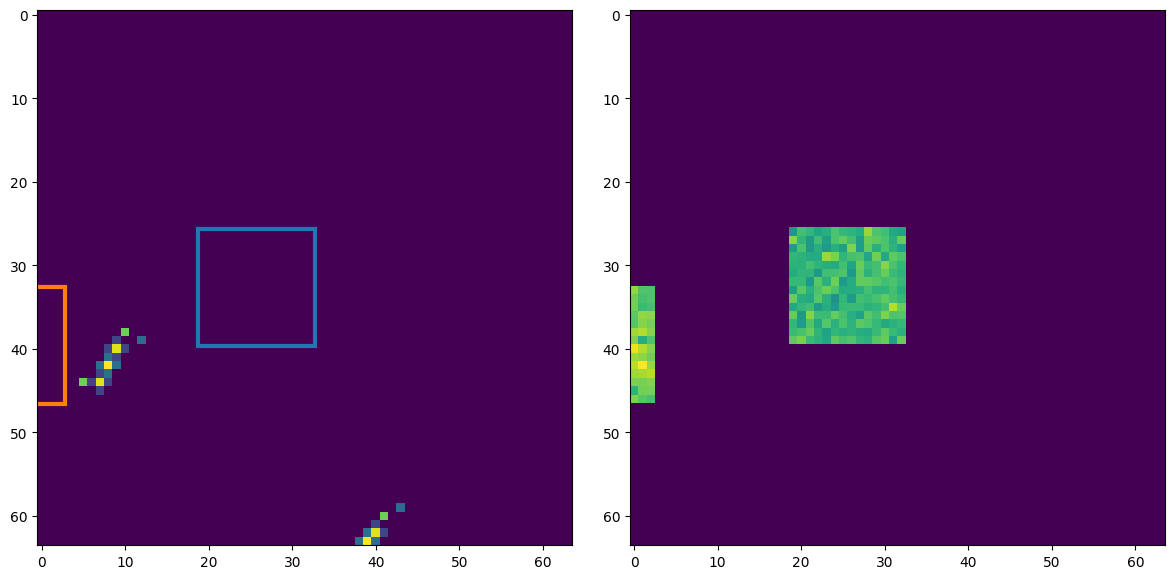

In [35]:
b = 0
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
def animate(i):
  axes[0].cla()
  axes[0].imshow(test_data[b, i])
  axes[1].cla()
  axes[1].imshow(out["frames_recon"][0, b, i])
  for d in range(2):
    where = 0.5 * (out[f"z_where_{i}"][0, b, d] + 1) * (frame_size - 14) - 0.5
    color = colors[d]
    axes[0].add_patch(
        Rectangle(where, 14, 14, edgecolor=color, lw=3, fill=False)
    )
plt.rc("animation", html="jshtml")
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=range(10), interval=300)
writer = animation.PillowWriter(fps=15)
ani.save("bmnist.gif", writer=writer)
plt.show()


In [18]:
i = 0
b = 3
d = 0
where = 0.5 * (out[f"z_where_{i}"][0, b, d] + 1) * (frame_size - 14) - 0.5

In [19]:
out[f"z_where_{i}"][0, b, d]

Array([0.15286748, 0.44975227], dtype=float32)

In [20]:
where

Array([28.321686, 35.74381 ], dtype=float32)

In [21]:
out.keys()

dict_keys(['frames', 'frames_recon', 'worm_frames', 'worms', 'z_where_0', 'z_where_1', 'z_where_2', 'z_where_3', 'z_where_4', 'z_where_5', 'z_where_6', 'z_where_7', 'z_where_8', 'z_where_9'])

In [22]:
network = coix.util.BindModule(bmnist_net, bmnist_params)

In [23]:
out_z_where = jnp.stack([out[f"z_where_{i}"] for i in range(10)], -2)
digits = crop_frames(test_data_tiled, out_z_where, 14)
gru_out = network.encode_what(digits)

In [24]:
gru_out[24]

Array([[[-0.0036361 , -0.00363905],
        [-0.310714  , -0.0036361 ],
        [-0.00363863, -0.00363601],
        [-0.32819477, -0.01364572],
        [-0.00363434, -0.00363863],
        [-0.0036361 , -0.00363863]],

       [[-0.00363601, -0.0036361 ],
        [-0.310714  , -0.00363992],
        [-0.00363863, -0.00363601],
        [-0.3282078 , -0.01365689],
        [-0.00363863, -0.0036361 ],
        [-0.0036361 , -0.0036361 ]],

       [[-0.0036361 , -0.00363905],
        [-0.310714  , -0.0036361 ],
        [-0.0036361 , -0.0036361 ],
        [-0.32819736, -0.01364578],
        [-0.0036361 , -0.0036361 ],
        [-0.0036361 , -0.00363905]],

       [[-0.00363601, -0.0036361 ],
        [-0.310714  , -0.00363863],
        [-0.00363905, -0.00363601],
        [-0.3282078 , -0.01365689],
        [-0.0036361 , -0.00363434],
        [-0.00363905, -0.00363863]],

       [[-0.00363863, -0.0036361 ],
        [-0.310714  , -0.00363863],
        [-0.0036361 , -0.00363601],
        [-0.32821286

In [25]:
gru_out[23]

Array([[[6.9245462, 6.9245434],
        [4.8942523, 6.9245462],
        [6.924541 , 6.9245467],
        [5.541922 , 7.23274  ],
        [6.9245596, 6.924541 ],
        [6.9245462, 6.924541 ]],

       [[6.9245467, 6.9245462],
        [4.8942523, 6.924543 ],
        [6.924541 , 6.9245467],
        [5.5419173, 7.2327447],
        [6.924541 , 6.9245462],
        [6.9245462, 6.9245462]],

       [[6.9245462, 6.9245434],
        [4.8942523, 6.9245462],
        [6.9245462, 6.9245462],
        [5.541929 , 7.2327385],
        [6.9245462, 6.9245462],
        [6.9245462, 6.9245434]],

       [[6.9245467, 6.9245462],
        [4.8942523, 6.924541 ],
        [6.9245434, 6.9245467],
        [5.5419173, 7.2327447],
        [6.9245462, 6.9245596],
        [6.9245434, 6.924541 ]],

       [[6.924541 , 6.9245462],
        [4.8942523, 6.924541 ],
        [6.9245462, 6.9245467],
        [5.5419335, 7.232744 ],
        [6.9245434, 6.9245462],
        [6.9245462, 6.9245462]],

       [[6.9245596, 6.9245434]

In [26]:
seeded_kernel_what = numpyro.handlers.seed(kernel_what, jax.random.PRNGKey(0))
tr = numpyro.handlers.trace(seeded_kernel_what)(network, out, T=10)

In [27]:
duration = 0.55
snapshots = 10
kpoints = 6
box_size = 64

sim_fn = partial(
    worm_simulation,
    duration=duration,
    snapshots=snapshots,
    kpoints=kpoints,
)

In [28]:
worm_out = vmapped_sim_fn(sim_fn, tr[0]["sim_vars"])

In [29]:
tr[0]["sim_vars"]["x0"][0, 0, 0]

Array(-0.72237164, dtype=float32)

In [30]:
worm_out[0, 0, 0, 0]

Array([[-1.6375319 , -4.4281054 ],
       [-2.221491  , -2.612232  ],
       [-1.8227178 , -0.746921  ],
       [-0.7410806 ,  0.8242144 ],
       [ 0.48603708,  2.2845519 ],
       [ 1.4044651 ,  3.956346  ]], dtype=float32)

In [31]:
gru_out[4][0, 4]

Array([0.7950753 , 0.79507494], dtype=float32)

In [32]:
out["worms"][0, 0, 0, 3, :]

Array([[ 0.14297828, -0.6233801 ],
       [ 0.25388896, -0.5499334 ],
       [ 0.35933933, -0.4691898 ],
       [ 0.48430002, -0.3996135 ],
       [ 0.6498199 , -0.34233272],
       [ 0.8304969 , -0.29280734]], dtype=float32)

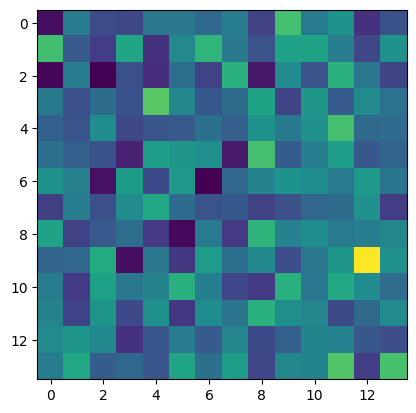

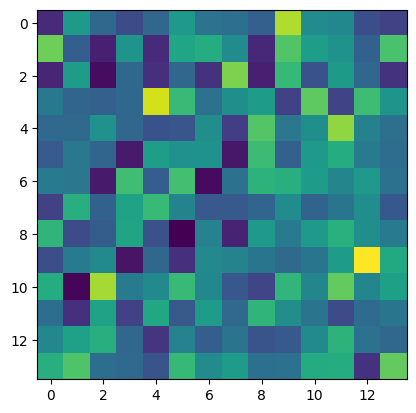

In [33]:
plt.figure()
plt.imshow(out["worm_frames"][0, 0, 0, 0, :, :])
plt.figure()
plt.imshow(out["worm_frames"][0, 0, 0, 9, :, :])

In [34]:
# network = coix.util.BindModule(bmnist_net, bmnist_params)

# out_z_where = jnp.stack([out[f"z_where_{i}"] for i in range(10)], -2)